# CONTRPUESTA CON LA MASCARA

ROI seleccionada: x=10, y=460, w=50, h=23
DataFrames guardados en: C:/cecs/mascaras/probando/series_tiempo\series_tiempo_intensidades_unet.csv, C:/cecs/mascaras/probando/series_tiempo\series_tiempo_intensidades_tradicional.csv, y C:/cecs/mascaras/probando/series_tiempo\series_tiempo_intensidades_combinado.csv
El gráfico comparativo ha sido guardado en C:/cecs/mascaras/probando/series_tiempo\comparacion_unet_tradicional.png


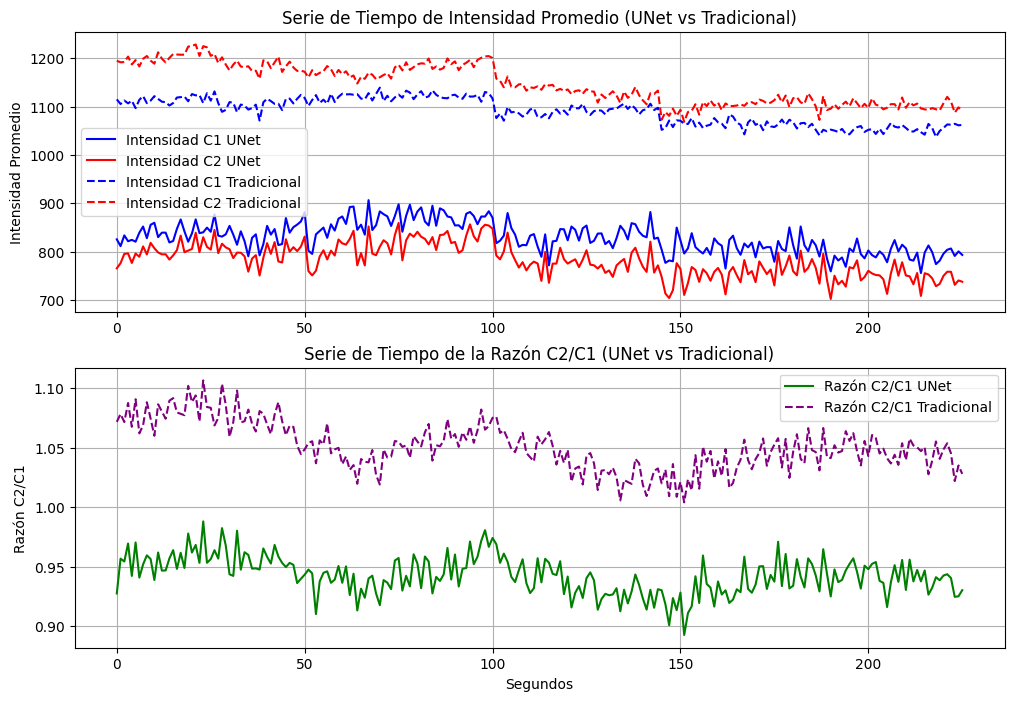

El gráfico del UNet ha sido guardado en C:/cecs/mascaras/probando/series_tiempo\unet_intensidad.png


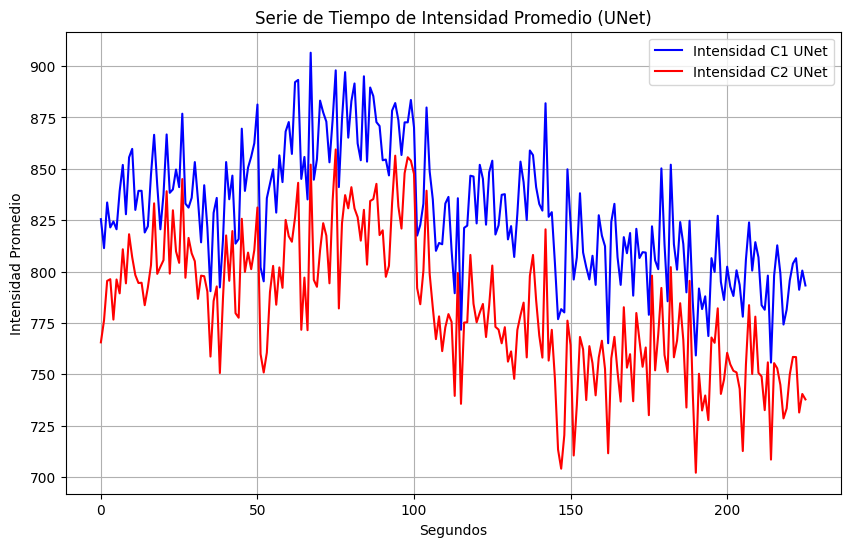

El gráfico tradicional ha sido guardado en C:/cecs/mascaras/probando/series_tiempo\tradicional_intensidad.png


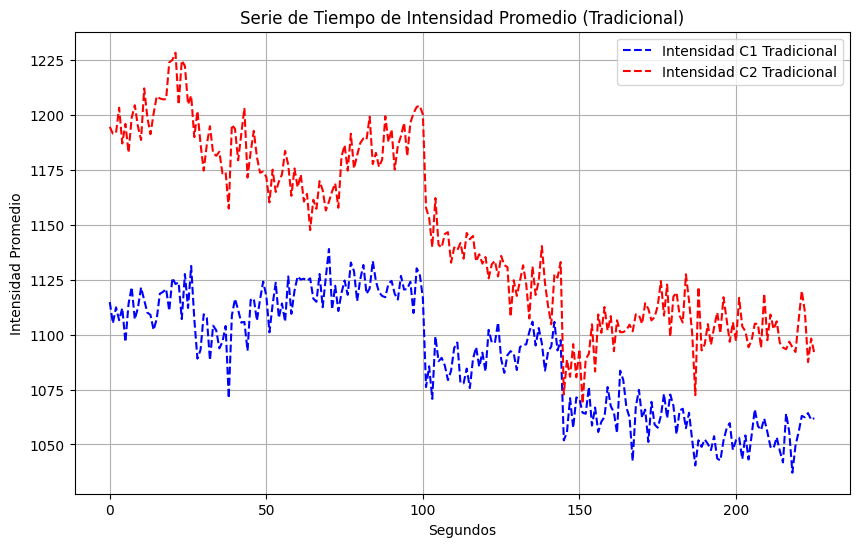

El gráfico de la razón C2/C1 del UNet ha sido guardado en C:/cecs/mascaras/probando/series_tiempo\unet_razon_c2_c1.png


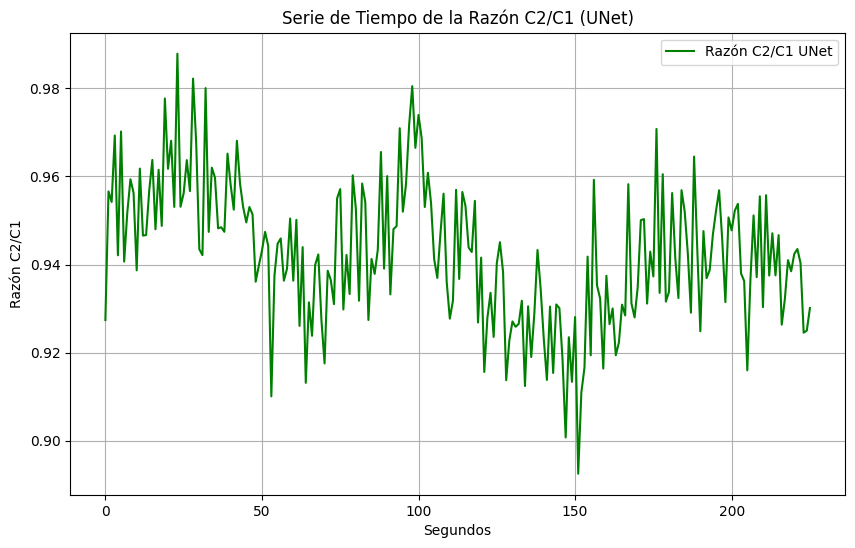

El gráfico de la razón C2/C1 tradicional ha sido guardado en C:/cecs/mascaras/probando/series_tiempo\tradicional_razon_c2_c1.png


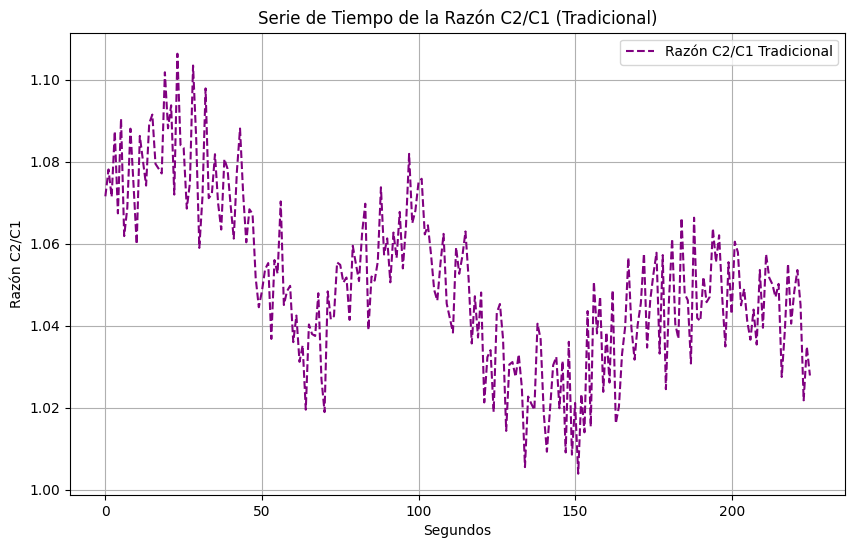

El gráfico de comparación de la razón C2/C1 ha sido guardado en C:/cecs/mascaras/probando/series_tiempo\comparacion_razon_unet_tradicional.png


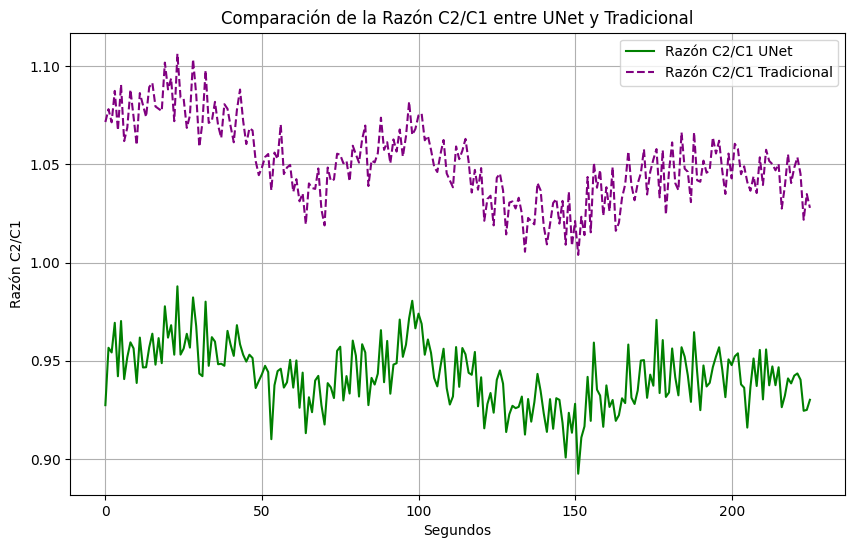

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tkinter as tk
from PIL import Image, ImageTk, ImageEnhance

# Función para seleccionar la ROI
class ROISelector:
    def __init__(self, root, image):
        self.root = root
        self.image = image
        self.roi = None

        self.canvas = tk.Canvas(root, width=image.width(), height=image.height())
        self.canvas.pack()
        self.canvas.create_image(0, 0, anchor=tk.NW, image=image)

        self.rect = None
        self.start_x = None
        self.start_y = None

        self.canvas.bind("<ButtonPress-1>", self.on_button_press)
        self.canvas.bind("<B1-Motion>", self.on_mouse_drag)
        self.canvas.bind("<ButtonRelease-1>", self.on_button_release)

    def on_button_press(self, event):
        self.start_x = event.x
        self.start_y = event.y
        self.rect = self.canvas.create_rectangle(self.start_x, self.start_y, self.start_x, self.start_y, outline='red')

    def on_mouse_drag(self, event):
        cur_x, cur_y = (event.x, event.y)
        self.canvas.coords(self.rect, self.start_x, self.start_y, cur_x, cur_y)

    def on_button_release(self, event):
        end_x, end_y = (event.x, event.y)
        self.roi = (self.start_x, self.start_y, end_x - self.start_x, end_y - self.start_y)
        self.root.quit()

# Función para seleccionar la ROI con la imagen y la máscara superpuestas
def seleccionar_roi_con_superposicion(imagen, mascara):
    imagen_normalizada = (imagen / 4090).astype(np.float32)  # Normalizar la imagen de 16 bits
    imagen_rgb = np.zeros((imagen.shape[0], imagen.shape[1], 3), dtype=np.float32)
    imagen_rgb[:, :, 0] = mascara / 255.0  # Canal rojo para la máscara
    imagen_rgb[:, :, 1] = imagen_normalizada  # Canal verde para la imagen original

    imagen_pil = Image.fromarray((imagen_rgb * 255).astype(np.uint8))

    root = tk.Tk()
    tk_image = ImageTk.PhotoImage(imagen_pil)
    selector = ROISelector(root, tk_image)
    root.mainloop()
    return selector.roi

# Función para cargar imágenes
def cargar_imagenes(ruta):
    imagenes = []
    nombres_archivos = []
    for archivo in sorted(os.listdir(ruta)):
        if archivo.endswith(('.tif', '.png', '.jpg', '.jpeg', '.bmp')):
            imagen = cv2.imread(os.path.join(ruta, archivo), cv2.IMREAD_UNCHANGED)
            imagenes.append(imagen)
            nombres_archivos.append(archivo)
    return imagenes, nombres_archivos

# Función para calcular el promedio de intensidad dentro de la ROI
def calcular_promedio_intensidad_roi(imagen, x, y, w, h):
    roi = imagen[y:y+h, x:x+w]
    promedio_intensidad = np.mean(roi)
    return promedio_intensidad

# Rutas a las carpetas de imágenes originales y máscaras segmentadas para C1 y C2
ruta_imagenes_C1 = r'C:\cecs\imagenes\C1'
ruta_imagenes_C1_segmentadas = r'C:\cecs\imagenes\C1_segmentadas'
ruta_imagenes_C2 = r'C:\cecs\imagenes\C2'
ruta_imagenes_C2_segmentadas = r'C:\cecs\imagenes\C2_segmentadas'

output_folder = 'C:/cecs/mascaras/probando/series_tiempo'
os.makedirs(output_folder, exist_ok=True)

# Cargar las imágenes originales y las máscaras segmentadas para C1 y C2
imagenes_C1, nombres_C1 = cargar_imagenes(ruta_imagenes_C1)
imagenes_C1_segmentadas, _ = cargar_imagenes(ruta_imagenes_C1_segmentadas)
imagenes_C2, nombres_C2 = cargar_imagenes(ruta_imagenes_C2)
imagenes_C2_segmentadas, _ = cargar_imagenes(ruta_imagenes_C2_segmentadas)

# Verificar que ambas listas de imágenes tengan el mismo tamaño
assert len(imagenes_C1) == len(imagenes_C1_segmentadas), "El número de imágenes y máscaras en C1 no coincide."
assert len(imagenes_C2) == len(imagenes_C2_segmentadas), "El número de imágenes y máscaras en C2 no coincide."

# Seleccionar la ROI en la primera imagen con la superposición
roi = seleccionar_roi_con_superposicion(imagenes_C1[0], imagenes_C1_segmentadas[0])
x, y, w, h = roi
print(f"ROI seleccionada: x={x}, y={y}, w={w}, h={h}")

# Listas para almacenar las intensidades promedio
intensidades_promedio_C1_metodo = []
intensidades_promedio_C2_metodo = []
intensidades_promedio_C1_tradicional = []
intensidades_promedio_C2_tradicional = []

# Multiplicación de la máscara por la imagen original para C1 y C2 (UNet) CAMBIO A MISMA MASCARA PARA AMBOS EXPERIMENTOS
for img_C1, img_C1_seg, img_C2, img_C2_seg in zip(imagenes_C1, imagenes_C1_segmentadas, imagenes_C2, imagenes_C1_segmentadas):
    masked_image_C1 = img_C1 * (img_C1_seg > 0)
    intensidad_promedio_C1 = calcular_promedio_intensidad_roi(masked_image_C1, x, y, w, h)
    intensidades_promedio_C1_metodo.append(intensidad_promedio_C1)
    
    masked_image_C2 = img_C2 * (img_C2_seg > 0)
    intensidad_promedio_C2 = calcular_promedio_intensidad_roi(masked_image_C2, x, y, w, h)
    intensidades_promedio_C2_metodo.append(intensidad_promedio_C2)

# Calcular las intensidades promedio tradicionales para C1 y C2 (sin máscaras)
for img_C1, img_C2 in zip(imagenes_C1, imagenes_C2):
    intensidad_promedio_C1 = calcular_promedio_intensidad_roi(img_C1 , x, y, w, h)
    intensidad_promedio_C2 = calcular_promedio_intensidad_roi(img_C2 , x, y, w, h)
    intensidades_promedio_C1_tradicional.append(intensidad_promedio_C1)
    intensidades_promedio_C2_tradicional.append(intensidad_promedio_C2)

# Crear DataFrames con las intensidades promedio
df_series_tiempo_metodo = pd.DataFrame({
    'Nombre_Archivo': nombres_C1,
    'Intensidad_Promedio_C1_UNet': intensidades_promedio_C1_metodo,
    'Intensidad_Promedio_C2_UNet': intensidades_promedio_C2_metodo
})

df_series_tiempo_tradicional = pd.DataFrame({
    'Nombre_Archivo': nombres_C1,
    'Intensidad_Promedio_C1_Tradicional': intensidades_promedio_C1_tradicional,
    'Intensidad_Promedio_C2_Tradicional': intensidades_promedio_C2_tradicional
})

# Crear un DataFrame combinado con ambos métodos
df_series_tiempo_combinado = pd.DataFrame({
    'Nombre_Archivo': nombres_C1,
    'Intensidad_Promedio_C1_UNet': intensidades_promedio_C1_metodo,
    'Intensidad_Promedio_C2_UNet': intensidades_promedio_C2_metodo,
    'Intensidad_Promedio_C1_Tradicional': intensidades_promedio_C1_tradicional,
    'Intensidad_Promedio_C2_Tradicional': intensidades_promedio_C2_tradicional
})

# Guardar los DataFrames en archivos CSV
csv_output_path_metodo = os.path.join(output_folder, 'series_tiempo_intensidades_unet.csv')
csv_output_path_tradicional = os.path.join(output_folder, 'series_tiempo_intensidades_tradicional.csv')
csv_output_path_combinado = os.path.join(output_folder, 'series_tiempo_intensidades_combinado.csv')

df_series_tiempo_metodo.to_csv(csv_output_path_metodo, index=False)
df_series_tiempo_tradicional.to_csv(csv_output_path_tradicional, index=False)
df_series_tiempo_combinado.to_csv(csv_output_path_combinado, index=False)

print(f'DataFrames guardados en: {csv_output_path_metodo}, {csv_output_path_tradicional}, y {csv_output_path_combinado}')


# Comparación gráfica
plt.figure(figsize=(12, 8))

# Gráfico de las intensidades promedio
plt.subplot(2, 1, 1)
plt.plot(df_series_tiempo_metodo['Intensidad_Promedio_C1_UNet'], label='Intensidad C1 UNet', color='blue')
plt.plot(df_series_tiempo_metodo['Intensidad_Promedio_C2_UNet'], label='Intensidad C2 UNet', color='red')
plt.plot(df_series_tiempo_tradicional['Intensidad_Promedio_C1_Tradicional'], label='Intensidad C1 Tradicional', color='blue', linestyle='--')
plt.plot(df_series_tiempo_tradicional['Intensidad_Promedio_C2_Tradicional'], label='Intensidad C2 Tradicional', color='red', linestyle='--')
plt.xlabel('')
plt.ylabel('Intensidad Promedio')
plt.title('Serie de Tiempo de Intensidad Promedio (UNet vs Tradicional)')
plt.legend()
plt.grid(True)

# Cálculo de las razones C2/C1
razon_metodo = df_series_tiempo_metodo['Intensidad_Promedio_C2_UNet'] / df_series_tiempo_metodo['Intensidad_Promedio_C1_UNet']
razon_tradicional = df_series_tiempo_tradicional['Intensidad_Promedio_C2_Tradicional'] / df_series_tiempo_tradicional['Intensidad_Promedio_C1_Tradicional']

# Aplicar límites a las razones para evitar valores extremos
razon_metodo = np.clip(razon_metodo, 0, 10)
razon_tradicional = np.clip(razon_tradicional, 0, 10)

# Gráfico de las razones
plt.subplot(2, 1, 2)
plt.plot(razon_metodo, label='Razón C2/C1 UNet', color='green')
plt.plot(razon_tradicional, label='Razón C2/C1 Tradicional', color='purple', linestyle='--')
plt.xlabel('Segundos')
plt.ylabel('Razón C2/C1')
plt.title('Serie de Tiempo de la Razón C2/C1 (UNet vs Tradicional)')
plt.legend()
plt.grid(True)

# Guardar el gráfico de comparación
output_plot_path = os.path.join(output_folder, 'comparacion_unet_tradicional.png')
plt.savefig(output_plot_path, dpi=300)
print(f"El gráfico comparativo ha sido guardado en {output_plot_path}")

plt.show()

# Gráfico del UNet por separado
plt.figure(figsize=(10, 6))
plt.plot(df_series_tiempo_metodo['Intensidad_Promedio_C1_UNet'], label='Intensidad C1 UNet', color='blue')
plt.plot(df_series_tiempo_metodo['Intensidad_Promedio_C2_UNet'], label='Intensidad C2 UNet', color='red')
plt.xlabel('Segundos')
plt.ylabel('Intensidad Promedio')
plt.title('Serie de Tiempo de Intensidad Promedio (UNet)')
plt.legend()
plt.grid(True)
output_plot_metodo = os.path.join(output_folder, 'unet_intensidad.png')
plt.savefig(output_plot_metodo, dpi=300)
print(f"El gráfico del UNet ha sido guardado en {output_plot_metodo}")
plt.show()

# Gráfico del tradicional por separado
plt.figure(figsize=(10, 6))
plt.plot(df_series_tiempo_tradicional['Intensidad_Promedio_C1_Tradicional'], label='Intensidad C1 Tradicional', color='blue', linestyle='--')
plt.plot(df_series_tiempo_tradicional['Intensidad_Promedio_C2_Tradicional'], label='Intensidad C2 Tradicional', color='red', linestyle='--')
plt.xlabel('Segundos')
plt.ylabel('Intensidad Promedio')
plt.title('Serie de Tiempo de Intensidad Promedio (Tradicional)')
plt.legend()
plt.grid(True)
output_plot_tradicional = os.path.join(output_folder, 'tradicional_intensidad.png')
plt.savefig(output_plot_tradicional, dpi=300)
print(f"El gráfico tradicional ha sido guardado en {output_plot_tradicional}")
plt.show()

# Gráfico de la razón C2/C1 del UNet por separado
plt.figure(figsize=(10, 6))
plt.plot(razon_metodo, label='Razón C2/C1 UNet', color='green')
plt.xlabel('Segundos')
plt.ylabel('Razón C2/C1')
plt.title('Serie de Tiempo de la Razón C2/C1 (UNet)')
plt.legend()
plt.grid(True)
output_plot_razon_metodo = os.path.join(output_folder, 'unet_razon_c2_c1.png')
plt.savefig(output_plot_razon_metodo, dpi=300)
print(f"El gráfico de la razón C2/C1 del UNet ha sido guardado en {output_plot_razon_metodo}")
plt.show()

# Gráfico de la razón C2/C1 del tradicional por separado
plt.figure(figsize=(10, 6))
plt.plot(razon_tradicional, label='Razón C2/C1 Tradicional', color='purple', linestyle='--')
plt.xlabel('Segundos')
plt.ylabel('Razón C2/C1')
plt.title('Serie de Tiempo de la Razón C2/C1 (Tradicional)')
plt.legend()
plt.grid(True)
output_plot_razon_tradicional = os.path.join(output_folder, 'tradicional_razon_c2_c1.png')
plt.savefig(output_plot_razon_tradicional, dpi=300)
print(f"El gráfico de la razón C2/C1 tradicional ha sido guardado en {output_plot_razon_tradicional}")
plt.show()

# Gráfico comparativo de las razones entre ambos métodos
plt.figure(figsize=(10, 6))
plt.plot(razon_metodo, label='Razón C2/C1 UNet', color='green')
plt.plot(razon_tradicional, label='Razón C2/C1 Tradicional', color='purple', linestyle='--')
plt.xlabel('Segundos')
plt.ylabel('Razón C2/C1')
plt.title('Comparación de la Razón C2/C1 entre UNet y Tradicional')
plt.legend()
plt.grid(True)
output_plot_comparacion_razon = os.path.join(output_folder, 'comparacion_razon_unet_tradicional.png')
plt.savefig(output_plot_comparacion_razon, dpi=300)
print(f"El gráfico de comparación de la razón C2/C1 ha sido guardado en {output_plot_comparacion_razon}")
plt.show()


In [2]:
import pandas as pd
import numpy as np

# Ruta a los archivos CSV
csv_output_path_metodo = 'C:/cecs/mascaras/probando/series_tiempo/series_tiempo_intensidades_unet.csv'
csv_output_path_tradicional = 'C:/cecs/mascaras/probando/series_tiempo/series_tiempo_intensidades_tradicional.csv'

# Cargar los DataFrames
df_metodo = pd.read_csv(csv_output_path_metodo)
df_tradicional = pd.read_csv(csv_output_path_tradicional)

# Cálculo de la razón C2/C1 para ambos métodos
razon_metodo = df_metodo['Intensidad_Promedio_C2_UNet'] / df_metodo['Intensidad_Promedio_C1_UNet']
razon_tradicional = df_tradicional['Intensidad_Promedio_C2_Tradicional'] / df_tradicional['Intensidad_Promedio_C1_Tradicional']
razon_metodo = razon_metodo.replace([np.inf, -np.inf], np.nan).dropna()
razon_tradicional = razon_tradicional.replace([np.inf, -np.inf], np.nan).dropna()

# Cálculo del RMSE
rmse = np.sqrt(np.mean((razon_metodo - razon_tradicional) ** 2))

print(f'RMSE entre las razones C2/C1 de ambos métodos: {rmse}')
mae = np.mean(np.abs(razon_metodo - razon_tradicional))
print(f'MAE entre las razones C2/C1 de ambos métodos: {mae}')
mse = np.mean((razon_metodo - razon_tradicional) ** 2)
print(f'MSE entre las razones C2/C1 de ambos métodos: {mse}')

RMSE entre las razones C2/C1 de ambos métodos: 0.10871303519118708
MAE entre las razones C2/C1 de ambos métodos: 0.10822993505409828
MSE entre las razones C2/C1 de ambos métodos: 0.01181852402048028
